In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("colleges-sample.csv")
df.head()

,College,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private
0,University of Virginia,15849,5384,2678,74,95,11278,114,12212,3792,500,1000,90,92,9.5,22,13597,95,No
1,University of South Carolina at Columbia,7693,5815,2328,30,66,12594,3661,8074,3522,495,2941,84,88,16.9,18,8246,63,No
2,Univ. of Wisconsin at OshKosh,4800,2900,1515,14,48,7764,1472,6874,2394,518,1890,73,78,19.2,14,5901,56,No
3,University of Nebraska at Lincoln,6277,6003,3526,33,63,16454,3171,5595,3145,500,2070,86,92,15.1,48,6813,53,No
4,University of Pennsylvania,12394,5232,2464,85,100,9205,531,17020,7270,500,1544,95,96,6.3,38,25765,93,Yes


In [3]:
df.shape

(40, 19)

In [4]:
df.columns

Index(['College', 'Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc',
       'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board', 'Books',
       'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend',
       'Grad.Rate', 'Private'],
      dtype='str')

In [5]:
# save those info in the numpy version
# numpy improves efficiency
college_name_col = df['College'].to_numpy()
private_or_public_col = df['Private'].to_numpy()

In [6]:
x = df.drop(columns = ['College', 'Private'])
print(x.shape)

(40, 17)


In [7]:
import sys
print(sys.executable)


c:\Users\win\AppData\Local\Python\pythoncore-3.14-64\python.exe


In [8]:
!"c:\Users\win\AppData\Local\Python\pythoncore-3.14-64\python.exe" -m pip install scikit-learn



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from sklearn.preprocessing import StandardScaler
# standardize all the numerical features
x_std = StandardScaler().fit_transform(x)

In [66]:
from sklearn.neighbors import kneighbors_graph
k = 10
A = kneighbors_graph(
    x_std,
    n_neighbors=k,
    mode="connectivity",   # only cares about whether there is an edge or not
    include_self=False
)

# A is a sparse adjacency matrix of the k-nearest-neighbor graph
# The matrix A represents a directed, unweighted k-nearest-neighbor similarity graph.
# In order to build the laplacian matrix, we need to 
# use the symmetrization and normalization
# it becomes an undirected similarity graph suitable for Laplacian-based methods
# A[i, j] = 1 if point j is among the k nearest neighbors of point i
# A[i, j] = 0 otherwise

In [67]:
type(A)

scipy.sparse._csr.csr_matrix

In [68]:
sum(A)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 39 stored elements and shape (1, 40)>

In [69]:
# A is a sparse matrix, which is a memory-efficient way to store matrices that are mostly zeros
# To convert it to a dense matrix, we can use the .toarray() method
A_dense = A.toarray()

In [70]:
type(A_dense)

numpy.ndarray

In [71]:
# calculate the symmetric similarity matrix 
# The 0.5 normalize edge weights and avoid double-counting mutual neighbors, leading to a cleaner and more interpretable similarity graph.
# We do not strictly need the 0.5, but we include it to avoid double-counting edges and to keep similarity weights on a consistent scale.

W = 0.5 * (A_dense + A_dense.T)
# (A + A.T) turns “who points to whom” into “who is connected to whom,” producing a clean, undirected similarity graph.

In [72]:
# after we got the similarity graph, we should calculate the L matrix 
# axis = 1 means that we should calculate it by rows
# np.diag put those sum into diagonal matrix 
import numpy as np
D = np.diag(W.sum(axis=1))

In [73]:
L = D - W
L

array([[ 7.5,  0. ,  0. , ..., -1. ,  0. ,  0. ],
       [ 0. , 15.5, -0.5, ...,  0. ,  0. , -1. ],
       [ 0. , -0.5, 11. , ...,  0. ,  0. , -1. ],
       ...,
       [-1. ,  0. ,  0. , ...,  8. ,  0. , -0.5],
       [ 0. ,  0. ,  0. , ...,  0. ,  6. , -0.5],
       [ 0. , -1. , -1. , ..., -0.5, -0.5, 20. ]], shape=(40, 40))

In [74]:
# It is used to calculate the eigvals and eigvecs for the symmetric matrix
# btw the eign will sort the values by ascending order automatically
eigvals, eigvecs = np.linalg.eigh(L)

In [75]:
eigvals

array([7.13557460e-15, 2.25777607e+00, 3.07780251e+00, 4.52204170e+00,
       4.74133228e+00, 5.30565686e+00, 6.10467616e+00, 6.30666068e+00,
       6.43706359e+00, 6.76839933e+00, 6.81943057e+00, 7.37537976e+00,
       7.57328091e+00, 7.75393714e+00, 7.94063696e+00, 8.03839164e+00,
       8.47836759e+00, 8.74765589e+00, 8.97067562e+00, 9.37572786e+00,
       9.54893225e+00, 9.84612647e+00, 1.02174803e+01, 1.03511578e+01,
       1.06012028e+01, 1.13760666e+01, 1.16307489e+01, 1.16951491e+01,
       1.19725941e+01, 1.21837540e+01, 1.28891938e+01, 1.34621658e+01,
       1.39377748e+01, 1.39706575e+01, 1.49764639e+01, 1.65522173e+01,
       1.80309420e+01, 1.91768449e+01, 1.99576003e+01, 2.10280345e+01])

In [76]:
embedded_eigvecs_one = eigvecs[:, 1:2]

In [77]:
embedded_eigvecs_two = eigvecs[:, 2:3]

In [78]:
X_embed = eigvecs[:, 1:3]

In [79]:
import sys
print(sys.executable)

c:\Users\win\AppData\Local\Python\pythoncore-3.14-64\python.exe


In [80]:
!"c:\Users\win\AppData\Local\Python\pythoncore-3.14-64\python.exe" -m pip install matplotlib


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


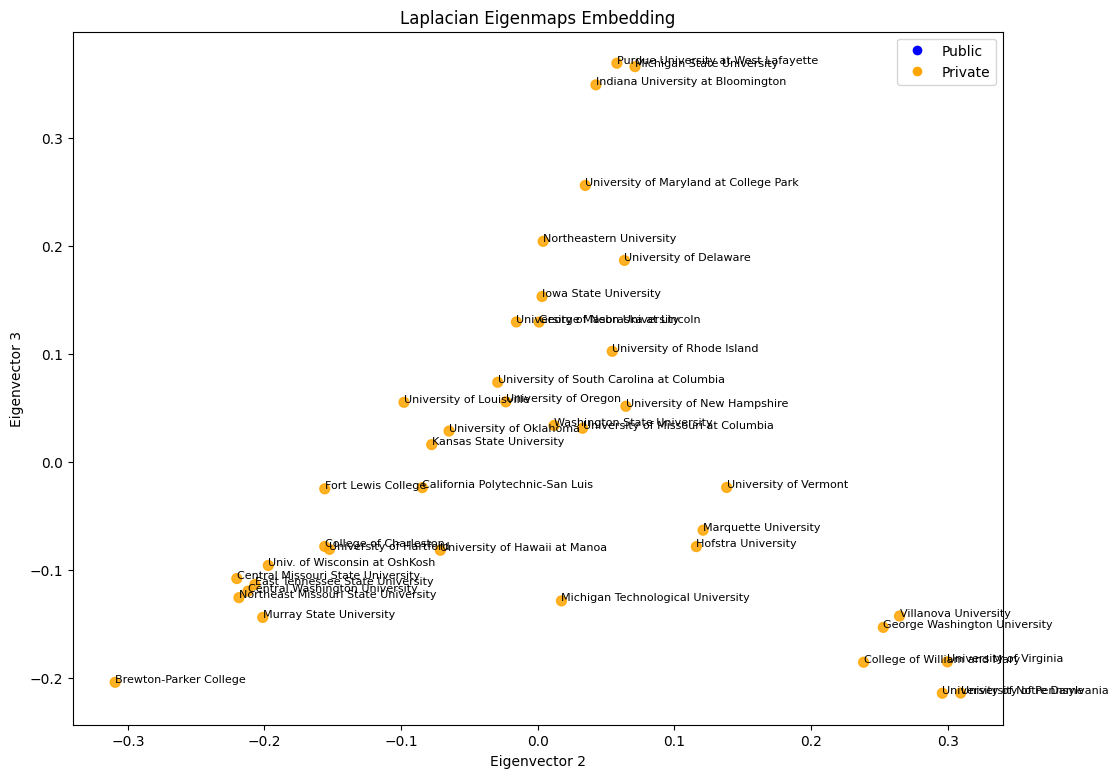

In [82]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

x = X_embed[:, 0]
y = X_embed[:, 1]

plt.figure(figsize=(12, 9))
plt.scatter(x, y, c=colors, s=50, alpha=0.85)

# 标注学校名称
for i, name in enumerate(college_name_col):
    plt.text(x[i], y[i], name, fontsize=8)

plt.xlabel("Eigenvector 2")
plt.ylabel("Eigenvector 3")
plt.title("Laplacian Eigenmaps Embedding")

# 手动 legend（和老师示例一样）
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Public',
           markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Private',
           markerfacecolor='orange', markersize=8)
]
plt.legend(handles=legend_elements)

plt.show()

